In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# solve the problem of "libdevice not found at ./libdevice.10.bc"
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/home/r10222035/.conda/envs/tf2'

2024-09-20 16:12:57.546180: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 16:12:57.631478: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# 生成假資料 n 維的高斯分佈

mu1 = [0, 0, 0, 0, 0]
cov1 = np.eye(5)
mu2 = [1, 1, 1, 1, 1]
cov2 = np.eye(5)

def generate_data(n_samples=10000):
    f1 = 0.8
    f2 = 0.1

    n_sig_1, n_bkg_1 = int(n_samples * f1), int(n_samples * (1 - f1))
    n_sig_2, n_bkg_2 = int(n_samples * f2), int(n_samples * (1 - f2))

    M1 = np.concatenate([np.random.multivariate_normal(mu1, cov1, size=n_sig_1), 
                         np.random.multivariate_normal(mu2, cov2, size=n_bkg_1)])
    M2 = np.concatenate([np.random.multivariate_normal(mu1, cov1, size=n_sig_2), 
                         np.random.multivariate_normal(mu2, cov2, size=n_bkg_2)])

    X = np.concatenate([M1, M2])
    y = np.array([1] * M1.shape[0]  + [0] * M2.shape[0])
    y_true = np.array([1] * n_sig_1 + [0] * n_bkg_1 + [1] * n_sig_2 + [0] * n_bkg_2)
    return X, y, y_true

In [3]:
X_test = np.concatenate([np.random.multivariate_normal(mu1, cov1, size=1000), 
                         np.random.multivariate_normal(mu2, cov2, size=1000)])
y_test = np.array([1] * 1000 + [0] * 1000)

In [4]:
# 建立神經網路模型
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(8, input_dim=input_dim, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [5]:
class MyTestingCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        super(MyTestingCallback, self).__init__()
        self.test_data = test_data
        self.testing_loss = []
        self.testing_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        # Test on another dataset
        results = self.model.evaluate(x=self.test_data[0], y=self.test_data[1], batch_size=1024)
        self.testing_loss.append(results[0])
        print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

        # Compute ACC
        y_pred = self.model.predict(self.test_data[0], batch_size=1024)
        ACC = get_highest_accuracy(self.test_data[1], y_pred)
        self.testing_accuracy.append(ACC)
        print(f'True ACC: Testing Loss = {results[0]:.3}, Testing Accuracy = {ACC:.3}')

def get_highest_accuracy(y_true, y_pred):
    _, _, thresholds = roc_curve(y_true, y_pred)
    # compute highest accuracy
    thresholds = np.array(thresholds)
    if len(thresholds) > 1000:
        thresholds = np.percentile(thresholds, np.linspace(0, 100, 1001))
    accuracy_scores = []
    for threshold in thresholds:
        accuracy_scores.append(accuracy_score(y_true, y_pred>threshold))

    accuracies = np.array(accuracy_scores)
    return accuracies.max()

In [6]:
def plot_event_distribution(X, y, y_true):
    if X.shape[0] > 3000:
        idx = np.random.choice(X.shape[0], 1000, replace=False)
        X = X[idx]
        y = y[idx]
        y_true = y_true[idx]
        
    # 畫訓練資料
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    ax[0].scatter(X[(y==1) & (y_true==1)][:, 0], X[(y==1) & (y_true==1)][:, 1], c='r', marker='+', alpha=0.3, label='signal in M1')
    ax[0].scatter(X[(y==0) & (y_true==1)][:, 0], X[(y==0) & (y_true==1)][:, 1], c='blue', marker='x', alpha=0.3, label='signal in M2')
    ax[0].scatter(X[(y==1) & (y_true==0)][:, 0], X[(y==1) & (y_true==0)][:, 1], c='lightcoral', marker='+', alpha=0.3, label='background in M1')
    ax[0].scatter(X[(y==0) & (y_true==0)][:, 0], X[(y==0) & (y_true==0)][:, 1], c='royalblue', marker='x', alpha=0.3, label='background in M2')
    ax[0].legend(frameon=False)

    ax[0].set_xlim(-5, 10)
    ax[0].set_ylim(-5, 10)

    ax[1].scatter(X[(y==1) & (y_true==1)][:, 0], X[(y==1) & (y_true==1)][:, 1], c='r', marker='+', alpha=0.3, label='signal in M1')
    ax[1].scatter(X[(y==0) & (y_true==1)][:, 0], X[(y==0) & (y_true==1)][:, 1], c='b', marker='x', alpha=0.3, label='signal in M2')
    ax[1].set_xlim(-5, 10)
    ax[1].set_ylim(-5, 10)
    ax[1].legend(frameon=False)

    ax[2].scatter(X[(y==1) & (y_true==0)][:, 0], X[(y==1) & (y_true==0)][:, 1], c='lightcoral', marker='+', alpha=0.3, label='background in M1')
    ax[2].scatter(X[(y==0) & (y_true==0)][:, 0], X[(y==0) & (y_true==0)][:, 1], c='royalblue', marker='x', alpha=0.3, label='background in M2')
    ax[2].set_xlim(-5, 10)
    ax[2].set_ylim(-5, 10)
    ax[2].legend(frameon=False)
    plt.show()

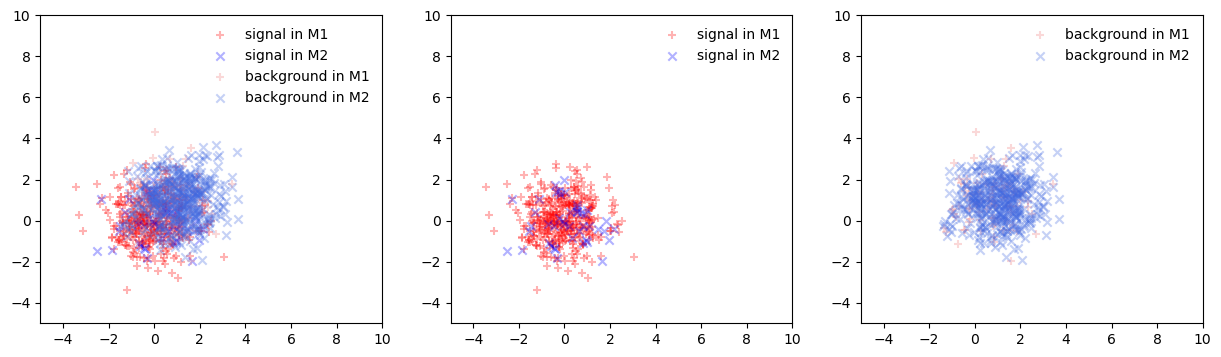

In [7]:
# 初始資料
X_train, y_train, y_true = generate_data()
X_val, y_val, y_true_val = generate_data(n_samples=1000)

plot_event_distribution(X_train, y_train, y_true)

Iteration 1
M1: sig: 8000, bkg: 1999
M2: sig: 1000, bkg: 9000
Epoch 1/50


2024-09-20 16:13:03.886378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 16:13:04.527019: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6
2024-09-20 16:13:06.486798: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-09-20 16:13:06.490529: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2fec017dc0 initialized for platform CUDA (this does not guarantee that XLA will 

2/2 [==============================] - 0s 4ms/step - loss: 0.5647 - accuracy: 0.7890
Testing Loss = 0.565, Testing Accuracy = 0.789
2/2 [==============================] - 0s 3ms/step
True ACC: Testing Loss = 0.565, Testing Accuracy = 0.814
20/20 [==============================] - 3s 30ms/step - loss: 0.6756 - accuracy: 0.5719 - val_loss: 0.6134 - val_accuracy: 0.7219
Epoch 2/50
2/2 [==============================] - 0s 4ms/step - loss: 0.4463 - accuracy: 0.8480
Testing Loss = 0.446, Testing Accuracy = 0.848
2/2 [==============================] - 0s 3ms/step
True ACC: Testing Loss = 0.446, Testing Accuracy = 0.851
20/20 [==============================] - 0s 19ms/step - loss: 0.5880 - accuracy: 0.7368 - val_loss: 0.5529 - val_accuracy: 0.7554
Epoch 3/50
2/2 [==============================] - 0s 3ms/step - loss: 0.3937 - accuracy: 0.8565
Testing Loss = 0.394, Testing Accuracy = 0.857
2/2 [==============================] - 0s 3ms/step
True ACC: Testing Loss = 0.394, Testing Accuracy = 0.85

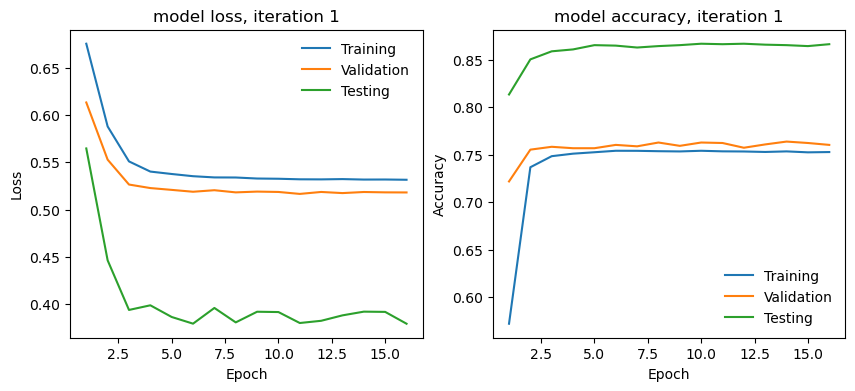

63/63 [==============================] - 0s 1ms/step


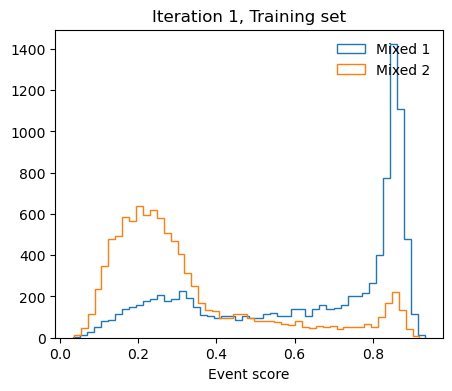

20/20 [==============================] - 0s 2ms/step - loss: 0.5324 - accuracy: 0.7544
Training Loss = 0.532, Training Accuracy = 0.754
2/2 [==============================] - 0s 2ms/step


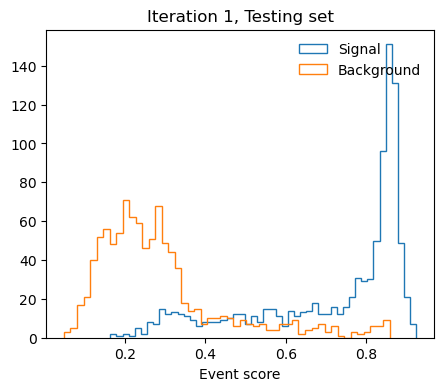

2/2 [==============================] - 0s 6ms/step - loss: 0.3791 - accuracy: 0.8585
Testing Loss = 0.379, Testing Accuracy = 0.859


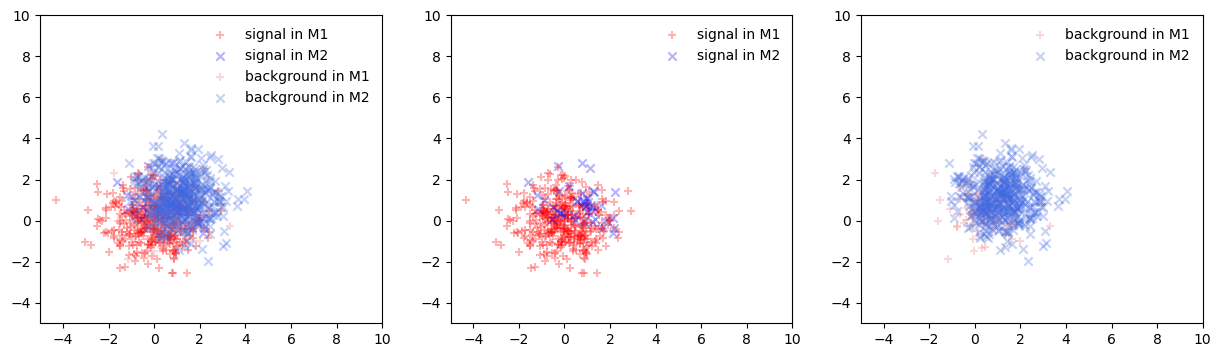

Iteration 2
M1: sig: 8100, bkg: 1899
M2: sig: 900, bkg: 9100
Epoch 1/50
2/2 [==============================] - 0s 4ms/step - loss: 0.4168 - accuracy: 0.8310
Testing Loss = 0.417, Testing Accuracy = 0.831
2/2 [==============================] - 0s 3ms/step
True ACC: Testing Loss = 0.417, Testing Accuracy = 0.847
20/20 [==============================] - 1s 26ms/step - loss: 0.5094 - accuracy: 0.7386 - val_loss: 0.3433 - val_accuracy: 0.8754
Epoch 2/50
2/2 [==============================] - 0s 4ms/step - loss: 0.3593 - accuracy: 0.8610
Testing Loss = 0.359, Testing Accuracy = 0.861
2/2 [==============================] - 0s 3ms/step
True ACC: Testing Loss = 0.359, Testing Accuracy = 0.864
20/20 [==============================] - 0s 19ms/step - loss: 0.2515 - accuracy: 0.9204 - val_loss: 0.1749 - val_accuracy: 0.9540
Epoch 3/50
2/2 [==============================] - 0s 4ms/step - loss: 0.4087 - accuracy: 0.8610
Testing Loss = 0.409, Testing Accuracy = 0.861
2/2 [=============================

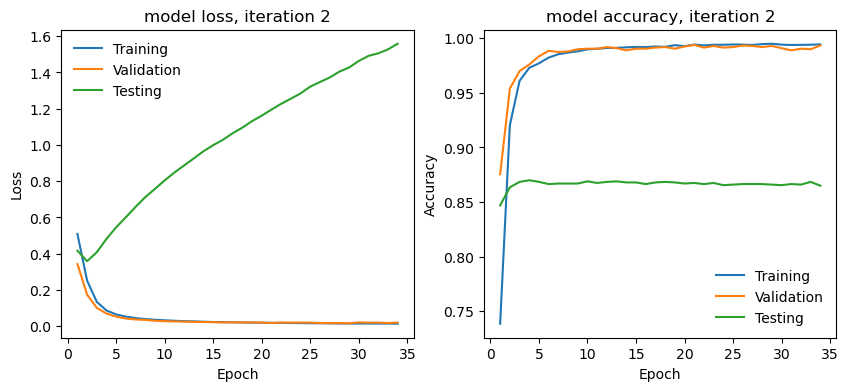

63/63 [==============================] - 0s 1ms/step


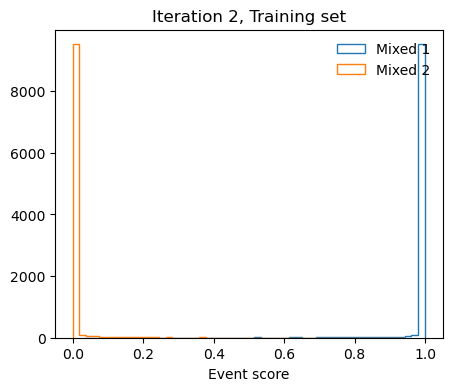

20/20 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.9950
Training Loss = 0.0138, Training Accuracy = 0.995
2/2 [==============================] - 0s 3ms/step


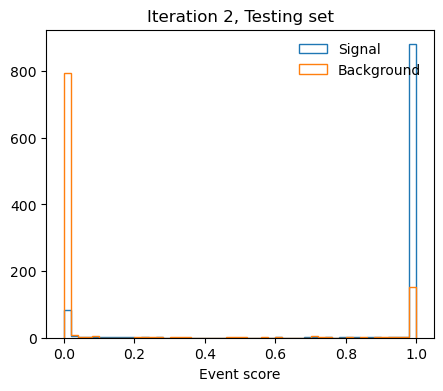

2/2 [==============================] - 0s 4ms/step - loss: 1.5581 - accuracy: 0.8600
Testing Loss = 1.56, Testing Accuracy = 0.86


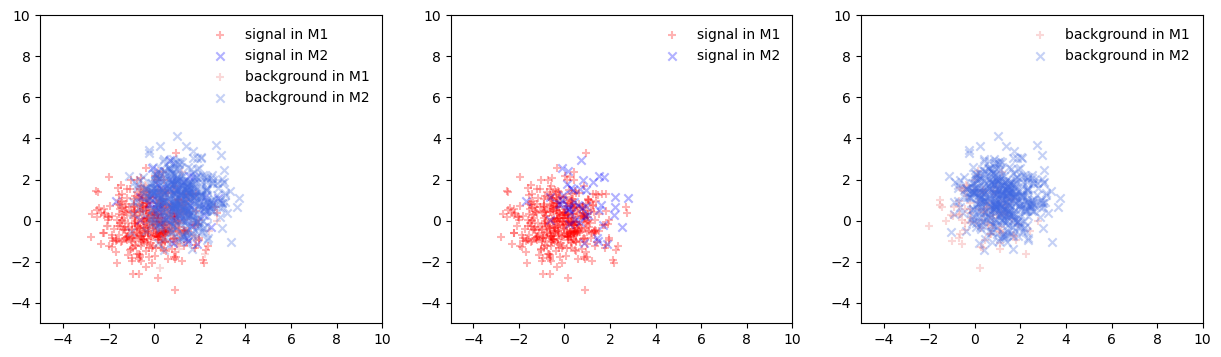

Iteration 3
M1: sig: 8105, bkg: 1894
M2: sig: 895, bkg: 9105
Epoch 1/50
2/2 [==============================] - 0s 4ms/step - loss: 0.4080 - accuracy: 0.8290
Testing Loss = 0.408, Testing Accuracy = 0.829
2/2 [==============================] - 0s 2ms/step
True ACC: Testing Loss = 0.408, Testing Accuracy = 0.844
20/20 [==============================] - 1s 27ms/step - loss: 0.4948 - accuracy: 0.7837 - val_loss: 0.3172 - val_accuracy: 0.8849
Epoch 2/50
2/2 [==============================] - 0s 4ms/step - loss: 0.3574 - accuracy: 0.8520
Testing Loss = 0.357, Testing Accuracy = 0.852
2/2 [==============================] - 0s 2ms/step
True ACC: Testing Loss = 0.357, Testing Accuracy = 0.857
20/20 [==============================] - 0s 18ms/step - loss: 0.2257 - accuracy: 0.9245 - val_loss: 0.1468 - val_accuracy: 0.9530
Epoch 3/50
2/2 [==============================] - 0s 4ms/step - loss: 0.4437 - accuracy: 0.8585
Testing Loss = 0.444, Testing Accuracy = 0.859
2/2 [=============================

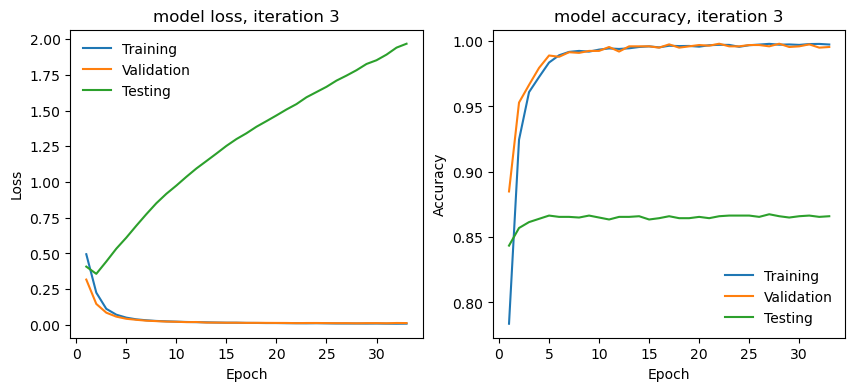

63/63 [==============================] - 0s 1ms/step


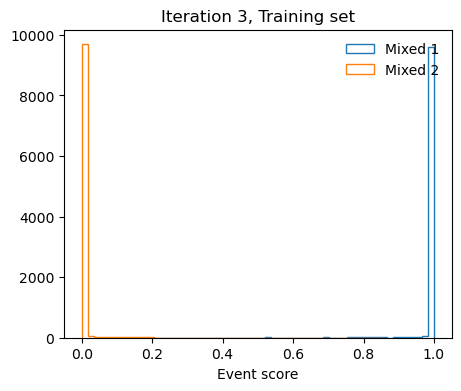

20/20 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.9970
Training Loss = 0.00847, Training Accuracy = 0.997
2/2 [==============================] - 0s 3ms/step


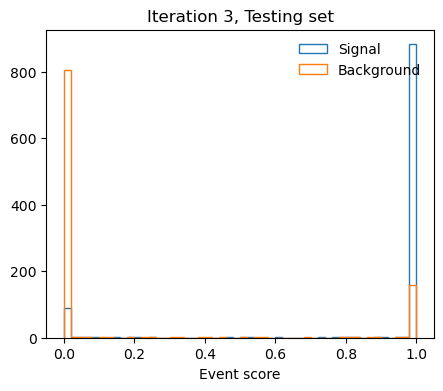

2/2 [==============================] - 0s 4ms/step - loss: 1.9688 - accuracy: 0.8615
Testing Loss = 1.97, Testing Accuracy = 0.862


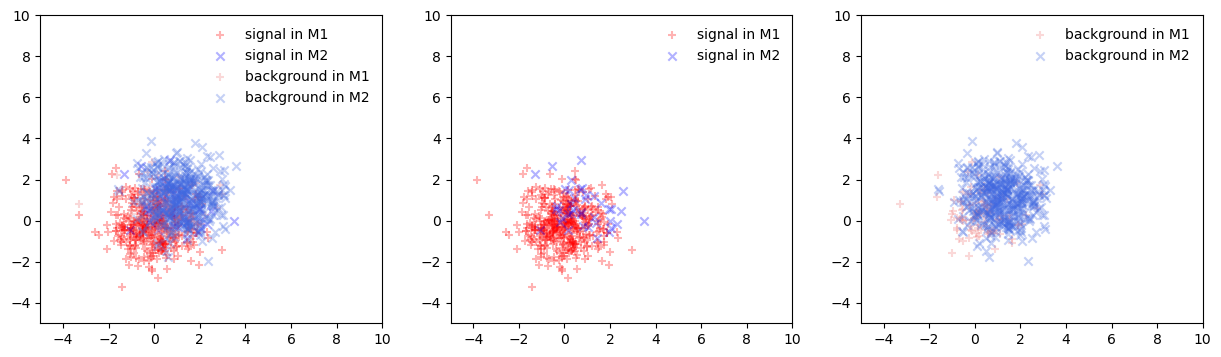

In [8]:
# 迭代重新分配資料和訓練
n_iterations = 3
for iteration in range(n_iterations):
    print(f'Iteration {iteration + 1}')
    
    # 檢查每個類別的數量
    n_sig_1 = np.sum(y_true[y_train == 1] == 1)
    n_bkg_1 = np.sum(y_true[y_train == 1] == 0)
    n_sig_2 = np.sum(y_true[y_train == 0] == 1)
    n_bkg_2 = np.sum(y_true[y_train == 0] == 0)
    print(f'M1: sig: {n_sig_1}, bkg: {n_bkg_1}')
    print(f'M2: sig: {n_sig_2}, bkg: {n_bkg_2}')

    testing_callback = MyTestingCallback((X_test, y_test))

    # 建立模型並訓練
    model = build_model(X_train.shape[1])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=5)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=1024, verbose=1, 
                        callbacks=[
                                    early_stopping,
                                    testing_callback,
                               ])

    # plot the training loss, accuracy
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    x = range(1, len(history.history['loss']) + 1)

    ax[0].plot(x, history.history['loss'], label='Training')
    ax[0].plot(x, history.history['val_loss'], label='Validation')
    ax[0].plot(x, testing_callback.testing_loss, label='Testing')

    ax[0].legend(frameon=False)
    ax[0].set_title(f'model loss, iteration {iteration + 1}')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(x, history.history['accuracy'], label='Training')
    ax[1].plot(x, history.history['val_accuracy'], label='Validation')
    ax[1].plot(x, testing_callback.testing_accuracy, label='Testing')

    ax[1].legend(frameon=False)
    ax[1].set_title(f'model accuracy, iteration {iteration + 1}')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    plt.show()


    # 利用模型重新分配訓練資料集
    y_predict = model.predict(X_train, batch_size=1024)
    # 找出 50% 的分界值
    threshold = np.percentile(y_predict, 50)
    y_train_new = (y_predict > threshold).astype(int).flatten()
    
    y_val_predict = model.predict(X_val)
    y_val_new = (y_val_predict > threshold).astype(int).flatten()

    # 畫 event score 的分布
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.hist(y_predict[y_train == 1], bins=50, histtype='step', label='Mixed 1')
    ax.hist(y_predict[y_train == 0], bins=50, histtype='step', label='Mixed 2')
    ax.legend(frameon=False)
    ax.set_title(f'Iteration {iteration + 1}, Training set')
    ax.set_xlabel('Event score')
    plt.show()

    results = model.evaluate(x=X_train, y=y_train, batch_size=1024)
    print(f'Training Loss = {results[0]:.3}, Training Accuracy = {results[1]:.3}')

    # 利用模型重新分配訓練資料集
    y_test_predict = model.predict(X_test, batch_size=1024)

    # 畫 event score 的分布
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.hist(y_test_predict[y_test == 1], bins=50, histtype='step', label='Signal')
    ax.hist(y_test_predict[y_test == 0], bins=50, histtype='step', label='Background')
    ax.legend(frameon=False)
    ax.set_title(f'Iteration {iteration + 1}, Testing set')
    ax.set_xlabel('Event score')
    plt.show()

    results = model.evaluate(x=X_test, y=y_test, batch_size=1024)
    print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

    plot_event_distribution(X_train, y_train_new, y_true)

    # 可以選擇重新合併兩個新的資料集或分別訓練不同的模型
    # 這裡假設繼續用原模型的預測結果來進行下一次迭代的訓練
    y_train = y_train_new
    y_val = y_val_new